In [1]:
%%bash
pip install numpy scipy scikit-image matplotlib

In [2]:
import torch
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd')
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn

In [3]:
# Move model to GPU and set to evaluation mode (inference only)
ssd_model.to('cuda')
ssd_model.eval()

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

In [4]:
uris = [
    'http://images.cocodataset.org/val2017/000000397133.jpg',
    'http://images.cocodataset.org/val2017/000000037777.jpg',
    'http://images.cocodataset.org/val2017/000000252219.jpg'
]

In [10]:
# Load and preprocess the images using NVIDIA's utility function
inputs = [utils.prepare_input(uri) for uri in uris]

# Convert list of images to a batch tensor
tensor = utils.prepare_tensor(inputs) # Shape of the first input image tensor
print(tensor[0].shape)

torch.Size([3, 300, 300])


In [11]:
# Perform object detection without computing gradients
with torch.no_grad():
  detections_batch = ssd_model(tensor) # Forward pass through SSD model

In [12]:
# Output contains bounding boxes, class scores, and more
detections_batch

(tensor([[[ 8.1638e-01,  6.2340e-01,  7.6705e-01,  ..., -2.1267e-01,
            3.7449e-02, -5.6229e-02],
          [ 3.2710e-02,  5.1494e-01,  1.0498e+00,  ..., -1.2594e-01,
           -1.7535e-01, -1.5219e-01],
          [-4.2087e+00, -2.1709e+00, -2.0718e+00,  ..., -1.0224e+00,
           -9.8508e-01,  8.3373e-01],
          [-4.5617e+00, -3.4244e+00, -2.0782e+00,  ..., -8.2774e-01,
            6.7410e-01, -8.4168e-01]],
 
         [[ 3.0832e-01, -2.2396e-02, -2.4771e-01,  ...,  1.1844e-01,
            1.1100e-01,  1.2097e-01],
          [ 1.8526e-01,  6.4315e-01,  4.0730e-01,  ...,  6.2464e-01,
            7.5405e-01,  3.7962e-01],
          [-1.5556e+00, -5.8792e-01, -2.6737e-01,  ..., -3.3463e-01,
           -4.6118e-01,  1.2635e+00],
          [-7.8018e-01, -3.7217e-01, -5.2670e-01,  ..., -9.1244e-01,
            1.1073e+00, -7.7028e-01]],
 
         [[ 2.0405e-01, -4.2278e-02, -2.8971e-01,  ..., -6.8506e-02,
           -1.1381e-03, -8.0792e-02],
          [ 3.5961e-02,  2.9110

In [14]:
detections_batch[1].shape

torch.Size([3, 81, 8732])

In [15]:
# Decode raw SSD model outputs to readable detection results
results_per_input = utils.decode_results(detections_batch)

# Filter out predictions below confidence threshold (0.40 here)
best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]

In [17]:
# Get COCO dataset class label mapping
classes_to_labels = utils.get_coco_object_dictionary()

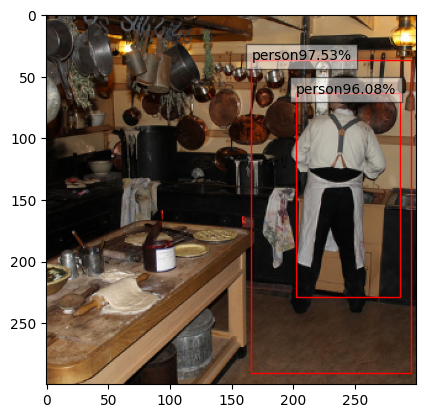

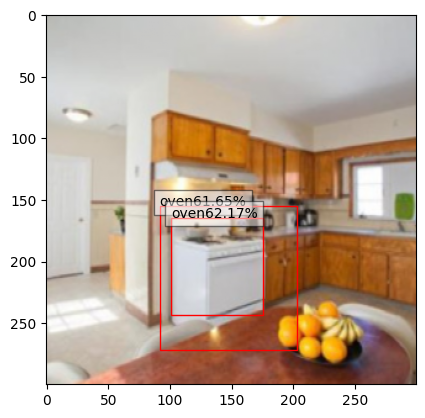

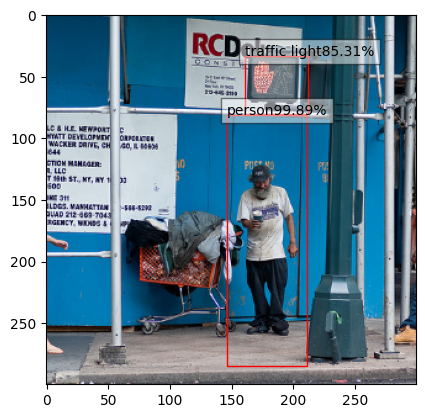

In [21]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

# Loop over each input image and show detection results
for image_idx in range(len(best_results_per_input)):
  fig, ax = plt.subplots(1) # Create a new figure for each image

  # Undo normalization and display image
  image = inputs[image_idx] / 2+0.5
  ax.imshow(image)

  # Get detection results
  bboxes, classes, confidences = best_results_per_input[image_idx]
  for idx in range(len(bboxes)):
    left, bot, right, top = bboxes[idx]

    # Convert from normalized to pixel coordinates (SSD default is 300x300)
    x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]

    # Draw bounding box
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    # Add label and confidence score
    ax.text(x, y, "{}{:.2F}%".format(classes_to_labels[classes[idx]-1],
                                     confidences[idx]*100),
            bbox=dict(facecolor='white',alpha = 0.5))

  plt.show()